### Install SECANT from GitHub
##### - Before running, make sure runtime has been set to GPU

In [ ]:
!pip install git+https://github.com/tarot0410/SECANT.git -q
!pip install umap-learn

     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 1.1 MB 49.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=87aa28b31db430b3ae144aa392ab5a2b44c5b7ce67197d348cf5fcba32f09d14
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=fa87f6bcf47263de71b92ac5f26ff8157679cd027dbf90f846a86962354c2b8d
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


### Import packages

In [ ]:
from SECANT import SECANT as SE
import torch
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as mcolors

### Mount Google Drive for accessing external data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Analyzing human bone marrow data (a subset of 10,000 cells from data in Seurat package)

In [ ]:
### Load in ADT confident cell type label
url = 'https://raw.githubusercontent.com/tarot0410/SECANT/main/real_data/Bone_marrow/'
ADT_df = pd.read_csv(url + 'label_bm_full.csv')
ADT_Lbl = SE.df_to_tensor(ADT_df)[:,0]   
ADT_Lbl = ADT_Lbl - 1 # make sure values in ADT_Lbl range from 0, and the maximum value refers to "uncertain" group
# Check uncertain rate in the given ADT label
print('P(uncertain)=', round(sum(ADT_Lbl.cpu().numpy()==int(torch.max(ADT_Lbl)))/ADT_Lbl.size(0),3))

# Load in RNA data (after dimension reduction)
RNA_df0 = pd.read_csv(url + 'bm_latent_D10_full.csv')
RNA_df0.drop(RNA_df0.columns[[0]], axis=1, inplace=True) # drop index column
data0 = SE.df_to_tensor(RNA_df0) # convert data matrix df to tensor
print('#cells=', data0.size(0))
print('#features=', data0.size(1))

P(uncertain)= 0.197
#cells= 30672
#features= 10


### UMAP for visualization (ADT confident cell types)

In [ ]:
# Set up UMAP
reducer = umap.UMAP(random_state=50)
embedding0 = reducer.fit_transform(data0.cpu())

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


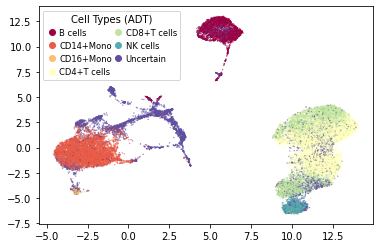

In [ ]:
# Colored by ADT confident cell types
scatter0 = plt.scatter(embedding0[:, 0],
           embedding0[:, 1],
           c=ADT_Lbl.cpu().numpy(), s=0.1, cmap='Spectral')
mylabel0=('B cells', 'CD14+Mono', 'CD16+Mono', 'CD4+T cells','CD8+T cells','NK cells', 'Uncertain')
legend0 = plt.legend(handles=scatter0.legend_elements()[0], labels=mylabel0, loc="best", title="Cell Types (ADT)", fontsize="small", ncol=2, columnspacing = 0.01, handlelength =1.5, handletextpad =0.1)

### Run SECANT

In [ ]:
### Input one configuration of concordance matrix
# Example: {B:4; CD14+ Mono:3; CD16+ Mono: 1; CD4+ T:2; CD8+ T:2; NK:1}
# Determine based on prior knowledge or data-driven (check 'Search_Best_Config' section)
concordance_config = [4,3,1,2,2,1]

### Main function to run SECANT
startTime = time.perf_counter()
SE_rslt = SE.SECANT_CITE(data0, concordance_config, ADT_Lbl)
print('running time {}'.format(time.perf_counter()-startTime)) 

### Core outputs
# cluster labels
lbl_out = SE_rslt.lbl
# concordance matrix
conMtxFinal = SE_rslt.conMtxFinal 
# cluster weights
wgt_out = SE_rslt.wgt_out
# final converged log-likelihood
logLik_final = SE_rslt.logLik_final 

### Estimated distribution parameters
# cluster-specific mean vector
mu_out = SE_rslt.mu_out
# cluster-specific covariance matrix
scale_out = SE_rslt.scale3D_out
scale_out_t = scale_out.permute(0,2,1)
cov_out = scale_out @ scale_out_t

running time 20.68190823300006


### Check SECANT results

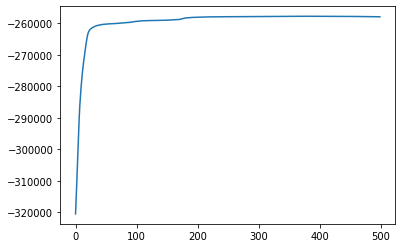

In [ ]:
### Check convergence of log-likelihoods
# log-likelihoods across all iterations
logLik_vec = SE_rslt.logLikVec 
logLik_vec_final = logLik_vec[logLik_vec != 0] 
plt.plot(logLik_vec_final)

In [ ]:
### Concordance matrix and cluster weights (test)
print('Concordance matrix:')
print(np.around(conMtxFinal.cpu().data.numpy(),3))
print('')
print('Cluster weights:')
print(np.around(wgt_out.cpu().data.numpy(),3))

Concordance matrix:
[[0.918 0.866 0.452 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.974 0.193 0.897 0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.583 0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.904 0.947 0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.741 0.952
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.781]
 [0.082 0.134 0.548 1.    0.026 0.807 0.103 0.417 0.096 0.053 0.259 0.048
  0.219]]

Cluster weights:
[0.057 0.056 0.027 0.057 0.133 0.053 0.075 0.014 0.108 0.164 0.087 0.126
 0.043]


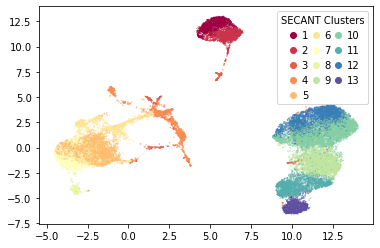

In [ ]:
### Visualization of SECANT cluster
se_lbl = lbl_out.cpu().data.numpy()
scatter1 = plt.scatter(embedding0[:, 0],
                       embedding0[:, 1],
                       c=se_lbl, s=0.1, cmap='Spectral')
mylabel1 = range(1, len(np.unique(se_lbl))+1)
legend1 = plt.legend(handles=scatter1.legend_elements(num=None)[0], labels=mylabel1, loc="best", title="SECANT Clusters", fontsize="medium", columnspacing = 0.01, handlelength =1.5, handletextpad =0.1, ncol=3)

### Compute posterior probability for each cell

In [ ]:
val, ind = SE_rslt.log_posteriors_final.max(dim=0)
max_post = val.exp() # posterior prob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


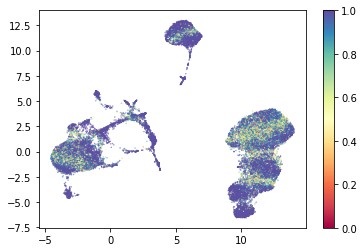

In [ ]:
# Colored by posterior probability
scatter2 = plt.scatter(embedding0[:, 0],
           embedding0[:, 1],
           c=max_post.data.cpu().numpy(), s=0.1, cmap='Spectral')

nValues = np.arange(0.0, 1.1, 0.1)
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap='Spectral')
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple)